# Package installation

Install any necessary software into the Julia installation. Note that this is only
necessary once after installing Julia. 

In [ ]:
import Pkg

Pkg.add("StatsBase") # Necessary functions like `mean` and `std`
Pkg.add("Distributions") # Necessary for bivariate gaussian distribtions
Pkg.add("Revise") # Convienent for modifications
Pkg.add("PyPlot") # Necessary for plotting
Pkg.add("HDF5") # Necessary for data loading
Pkg.add("LinearAlgebra") # Necessary for linear algebra functions

# Module and data loading

In [1]:
using Revise
using StatsBase
using Distributions
using PyPlot
using LinearAlgebra
import HDF5

# Include our code for generating bivariate distributions
includet("src/mv_random.jl");

In [2]:
# Load our data
if ! Base.Filesystem.isfile("pairwise_covariance.h5")
    error("Expected an h5 file called pairwise_covariance in the directory $(Base.Filesystem.pwd())")
end
fp = HDF5.h5open("pairwise_covariance.h5", "r")
pairwise_covariance = fp["pairwise_pc_covariance"][]
# Remove any pair-wise covariance values that are NaN (cells are non-overlapping in time)
pairwise_covariance = pairwise_covariance[.! isnan.(pairwise_covariance)]
mean_firing_rates = fp["mean_firing_rates"][]
close(fp)

# Function definitions

In [3]:
"""
    generate_covariance_matrix(simulated_mean_firing_rates, pairwise_covariance)


Construct a num_neurons x num_neurons covariance matrix by pulling random
covariance values from an emperically found distribution of pairwise covariance
values passed in via the `pairwise_covariance` input. The number of neurons
is specified by the length of the simulated_mean_firing_rates vector.

Returns:
 - An num_neurons x num_neurons random covariance matrix 
"""
function generate_covariance_matrix(simulated_mean_firing_rates::AbstractVector{<:Real}, 
        pair_wise_covariance::AbstractVector{<:Real})
    num_neurons = length(simulated_mean_firing_rates)
    
    covariance_matrix = zeros(num_neurons, num_neurons)
    for i = 1:num_neurons
        covariance_matrix[i, i] = simulated_mean_firing_rates[i] ./ 1000
        for j = i+1:num_neurons
            rand_index = rand(1:length(pair_wise_covariance))
            covariance_matrix[i, j] = pair_wise_covariance[rand_index]
            covariance_matrix[j, i] = covariance_matrix[i, j]
        end
    end
    return covariance_matrix
end

"""
    plot_covariance_matrix(covariance_matrix)

Convenience function for plotting the num_neurons x num_neurons
covariance matrix
"""
function plot_covariance_matrix(covariance_matrix::AbstractMatrix)
    num_neurons = size(covariance_matrix, 1)
    fig = figure()
    pcolormesh(1:1:size(covariance_matrix, 1), 1:1:size(covariance_matrix, 1), covariance_matrix)
    ylim(num_neurons, 1)
    colorbar()
    clim(minimum(covariance_matrix), maximum(covariance_matrix))
    return fig
end

plot_covariance_matrix

In [4]:
"""
    generate_triplet_ccg(spiketrains::Matrix)

Generate a "triplet" CCG. This is the probability of PC2 and PC3
firing as a function of PC1. In probability, this is equivalent to
plotting:
  Pr[PC2(t) = 1, PC3(t) = 1 | PC1(0) = 1] 
Note that this function does not account for coordinated changes
in firing rates between the three neurons, as the mean firing rates
for each of the cells is expected to be simulated and, therefore,
unchanging.

The spiketrains are assumed to be on the same timescale as time_axis 
(e.g., in 1ms bins)

Returns the ccg in units of probability, subtracting off the expected
probability of overlaps (E[PC1, PC2])

"""
function generate_triplet_ccg(spiketrains::AbstractMatrix; time_axis::AbstractRange=-100e-3:1e-3:100e-3)
    @assert size(spiketrains, 1) == 3
    
    # Compute the joint spiketrain between the second and third PC
    joint_spiketrain = (spiketrains[2, :] .* spiketrains[3, :])
    
    # Convert the PC1 spiketrain to spike indices
    I = findall(spiketrains[1, :] .!= 0)
    
    spike_counts = zeros(length(time_axis)) # Times we see joint_spiketrain !.= 0
    total_counts = zeros(length(time_axis)) # Times we actually have data
    pre_indices = Integer(round(time_axis[1] / step(time_axis)))
    
    for i = I # Loop over PC1's spikes
        for j = 1:length(time_axis)
            index = (i + pre_indices) + j - 1
            if (index < 1) || (index > size(spiketrains, 2))
                continue
            end
            total_counts[j] += 1
            spike_counts[j] += (joint_spiketrain[index] .!= 0)
        end
    end
    #return (spike_counts ./ total_counts) .- mean(joint_spiketrain)
    return (spike_counts ./ total_counts) .- mean(spiketrains[2, :]) .* mean(spiketrains[3, :])
end

generate_triplet_ccg

# Estimating triplet synchrony via simulation

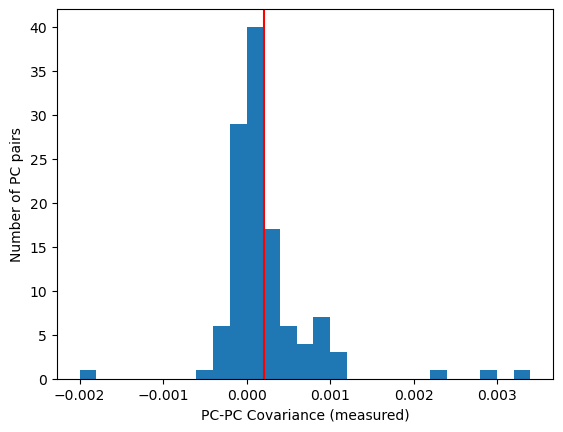

In [5]:
# Plot our distribution of pair-wise covariance matrices
h = StatsBase.fit(StatsBase.Histogram, pairwise_covariance, nbins=25)
bar(h.edges[1][1:end-1] .+ diff(h.edges[1]) / 2.0, h.weights, mean(diff(h.edges[1])))
axvline(mean(pairwise_covariance), color="r")

xlabel("PC-PC Covariance (measured)")
ylabel("Number of PC pairs");

In [10]:
# Construct simulated triplets by pulling values from our emperical firing rate
# and pair-wise covariance distributions
num_triplets = 100
time_axis = -25e-3:1e-3:25e-3
refractory_period = 0e-3
simulated_triplet_ccgs = zeros(num_triplets, length(time_axis))

for triplet_index = 1:num_triplets
    simulated_firing_rates = rand(mean_firing_rates, 3) # Always a triplet
    # Correct the simulated firing rates to account for the refractory period
    # e.g., if we want the neuron to fire at 50 spk/s but the refactory period
    # is 5ms, we would actually fire at 1 / (1/50 + 5e-3) = 40 spk/s. To correct
    # for this, we need to artificially increase our mean firing rate.
    simulated_firing_rates = 1 ./ (1 ./ simulated_firing_rates .- refractory_period)
    
    covariance_matrix = generate_covariance_matrix(simulated_firing_rates, pairwise_covariance)
    
    # Run the simulation above and estimate the covariance matrix after the fact to ensure they match
    mv_correlated = estimate_multivariate_distribution(simulated_firing_rates, covariance_matrix);
    correlated_spiketrains = generate_spiketrain_from_multivariate_distribution(mv_correlated, duration=600, absolute_refractory_period=refractory_period);

    #For our correlated spike-trains, generate the triplet ccg
   simulated_triplet_ccgs[triplet_index, :] = generate_triplet_ccg(correlated_spiketrains, time_axis=time_axis)
end


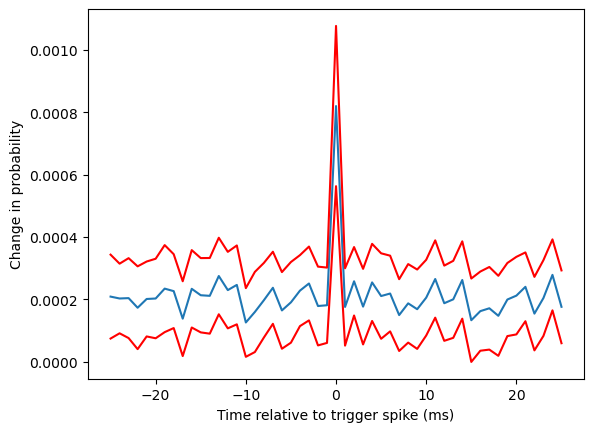

PyObject Text(24.0, 0.5, 'Change in probability')

In [11]:
# Plot our mean ccg
m = dropdims(mean(simulated_triplet_ccgs, dims=1), dims=1)
confidence_intervals = 1.96 * dropdims(std(simulated_triplet_ccgs, dims=1), dims=1) / sqrt(num_triplets)
plot(time_axis * 1000, m)
plot(time_axis * 1000, m - confidence_intervals, color="r")
plot(time_axis * 1000, m + confidence_intervals, color="r")
xlabel("Time relative to trigger spike (ms)")
ylabel("Change in probability")